In [19]:
from pyspark.sql import SparkSession

In [20]:

spark = SparkSession.builder \
    .appName("YelpDataAnalysis") \
    .getOrCreate()

In [21]:
yelp_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

In [22]:
yelp_df.printSchema()
yelp_df.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [23]:
arizona_df = yelp_df.filter(yelp_df["state"] == "AZ")

# Show first few rows
arizona_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out...|      85705|      

In [24]:
# arizona_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

In [25]:
yelp_df.select("categories").distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------+
|Arts & Entertainment, Event Planning & Services, Venues & Event Spaces, Museums                                              |
|Food, Convenience Stores, Restaurants, Food Delivery Services, Local Flavor, Delis                                           |
|Automotive, Auto Repair, Towing, Body Shops, Oil Change Stations, Auto Parts & Supplies, Tires                               |
|Makeup Artists, Hair Salons, Beauty & Spas                                                                                   |
|Breweries, American (New), Restaurants, Burgers, American (Traditional), Gastropubs, Brewpubs, Food, Fi

In [26]:
# Filter for businesses in the 'Mobile Phone Accessories' category
MPA_df = arizona_df.filter(arizona_df["categories"].contains("Mobile Phone Accessories"))

# Show filtered dataset
MPA_df.show(5)


+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|2990 N Campbell A...|{null, null, null...|e5zr_YpVmrnZsF_9C...|Shopping, Local S...|Tucson|{10:0-20:0, 0:0-0...|      1|32.2609375188|-110.9434187561|            T-Mobile|      85719|          12|  3.0|   AZ|
|2485 N Swan Rd, S...|{null, null, null...|-t9dKUGyLHGww3S3L...|IT Services & Com...|Tucson|{9:0-18:0, 0:0-0:...|      1|32.2518628995|-110.8933111453|         

In [28]:
MPA_df.createOrReplaceTempView("mobile_phone_accessories")

In [29]:
query_avg_stars = """
SELECT 
    AVG(stars) AS AvgStars
FROM mobile_accessories
"""
avg_stars_result = spark.sql(query_avg_stars)
print("Average Star Rating for Mobile Phone Accessories:")
avg_stars_result.show()


Average Star Rating for Mobile Phone Accessories:
+-----------------+
|         AvgStars|
+-----------------+
|2.893617021276596|
+-----------------+



In [30]:
query_open_closed = """
SELECT 
    is_open AS OpenStatus,
    COUNT(*) AS BusinessCount
FROM mobile_accessories
GROUP BY is_open
"""
open_closed_result = spark.sql(query_open_closed)
print("Count of Open vs. Closed Businesses:")
open_closed_result.show()


Count of Open vs. Closed Businesses:
+----------+-------------+
|OpenStatus|BusinessCount|
+----------+-------------+
|         0|           10|
|         1|           37|
+----------+-------------+



In [31]:
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
reviews_df.createOrReplaceTempView("reviews")

query_top_zipcodes = """
SELECT 
    b.postal_code AS ZipCode,
    COUNT(r.review_id) AS ReviewCount
FROM mobile_accessories b
JOIN reviews r ON b.business_id = r.business_id
GROUP BY b.postal_code
ORDER BY ReviewCount DESC
LIMIT 5
"""
top_zipcodes_result = spark.sql(query_top_zipcodes)
print("Top 5 Zip Codes by Review Count:")
top_zipcodes_result.show()

Top 5 Zip Codes by Review Count:


+-------+-----------+
|ZipCode|ReviewCount|
+-------+-----------+
|  85711|        124|
|  85719|        120|
|  85712|         68|
|  85705|         58|
|  85741|         57|
+-------+-----------+



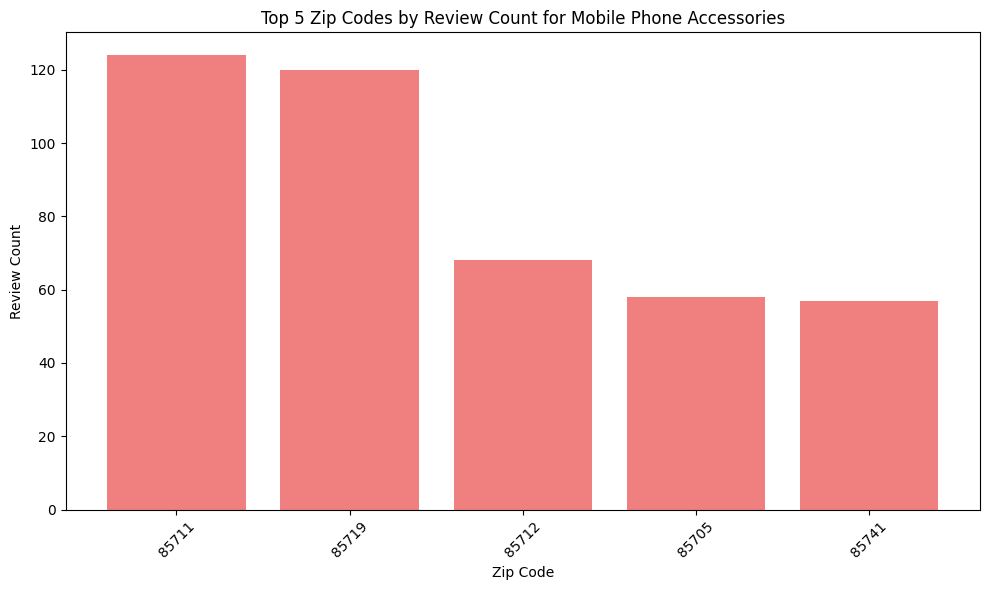

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect the results into a Pandas DataFrame
top_zipcodes_pd = top_zipcodes_result.toPandas()

# Plotting
plt.figure(figsize=(10, 6))

# Creating a bar plot
plt.bar(top_zipcodes_pd['ZipCode'], top_zipcodes_pd['ReviewCount'], color='lightcoral')

# Adding labels and title
plt.xlabel('Zip Code')
plt.ylabel('Review Count')
plt.title('Top 5 Zip Codes by Review Count for Mobile Phone Accessories')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()


In [32]:
query_positive_reviews = """
SELECT 
    b.name AS BusinessName,
    COUNT(r.stars) AS FiveStarReviews
FROM mobile_accessories b
JOIN reviews r ON b.business_id = r.business_id
WHERE r.stars = 5
GROUP BY b.name
ORDER BY FiveStarReviews DESC
LIMIT 5
"""
positive_reviews_result = spark.sql(query_positive_reviews)
print("Businesses with the Most Positive Reviews:")
positive_reviews_result.show()


Businesses with the Most Positive Reviews:


+------------+---------------+
|BusinessName|FiveStarReviews|
+------------+---------------+
|  uBreakiFix|             64|
|    T-Mobile|             50|
|  AT&T Store|             34|
|Screens Plus|             29|
|Sprint Store|             27|
+------------+---------------+



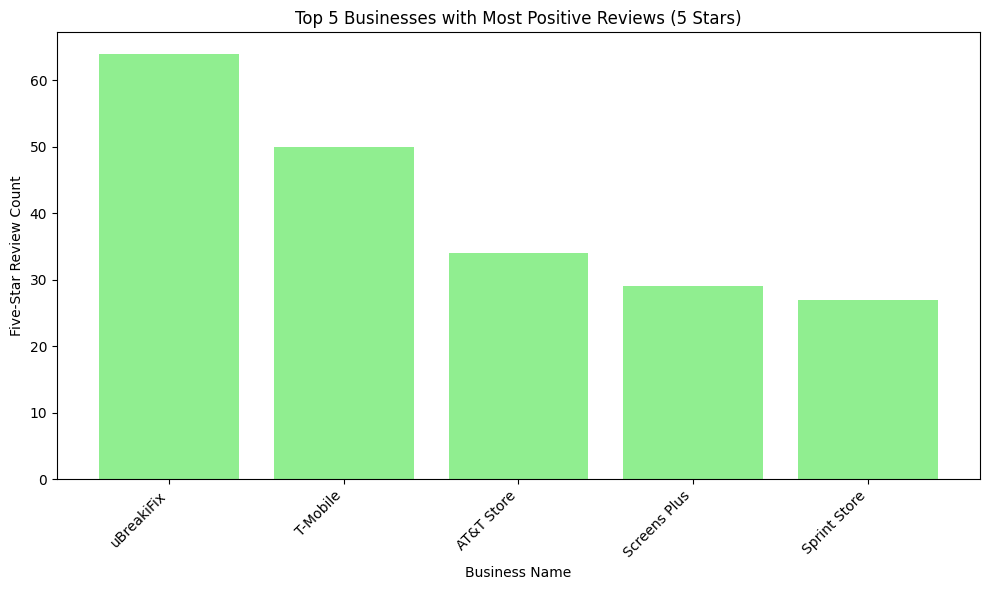

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect the results into a Pandas DataFrame
positive_reviews_pd = positive_reviews_result.toPandas()

# Plotting
plt.figure(figsize=(10, 6))

# Creating a bar plot
plt.bar(positive_reviews_pd['BusinessName'], positive_reviews_pd['FiveStarReviews'], color='lightgreen')

# Adding labels and title
plt.xlabel('Business Name')
plt.ylabel('Five-Star Review Count')
plt.title('Top 5 Businesses with Most Positive Reviews (5 Stars)')
plt.xticks(rotation=45, ha='right')  # Rotate business names for better visibility

# Display the plot
plt.tight_layout()
plt.show()


In [33]:
checkins_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
checkins_df.createOrReplaceTempView("checkins")

query_weekly_checkins = """
SELECT 
    b.name AS BusinessName,
    c.date AS CheckInDate,
    COUNT(c.date) AS CheckInCount
FROM mobile_accessories b
JOIN checkins c ON b.business_id = c.business_id
GROUP BY b.name, c.date
ORDER BY CheckInCount DESC
LIMIT 10
"""
weekly_checkins_result = spark.sql(query_weekly_checkins)
print("Weekly Check-Ins for Top Businesses:")
weekly_checkins_result.show()


Weekly Check-Ins for Top Businesses:


+--------------------+--------------------+------------+
|        BusinessName|         CheckInDate|CheckInCount|
+--------------------+--------------------+------------+
|          AT&T Store|2010-10-30 23:43:...|           1|
|          AT&T Store|2011-02-27 20:27:...|           1|
|            T-Mobile|2014-08-06 14:47:...|           1|
|          AT&T Store| 2015-09-30 20:28:48|           1|
|            T-Mobile|2011-02-08 19:08:...|           1|
|            T-Mobile|2016-08-11 01:15:...|           1|
|Verizon Authorize...| 2015-09-08 01:28:26|           1|
|            T-Mobile|2011-04-12 00:43:...|           1|
|        Screens Plus|2017-05-23 01:57:...|           1|
|            T-Mobile|2013-10-01 21:32:...|           1|
+--------------------+--------------------+------------+



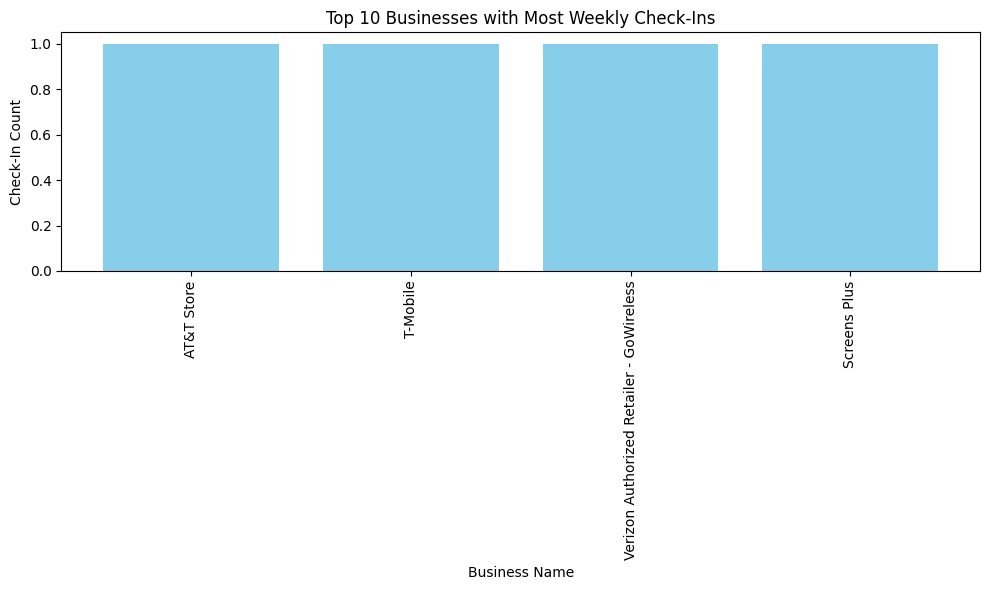

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect the results into a Pandas DataFrame
checkins_pd = weekly_checkins_result.toPandas()

# Plotting
plt.figure(figsize=(10, 6))

# Creating a bar plot
plt.bar(checkins_pd['BusinessName'], checkins_pd['CheckInCount'], color='skyblue')

# Adding labels and title
plt.xlabel('Business Name')
plt.ylabel('Check-In Count')
plt.title('Top 10 Businesses with Most Weekly Check-Ins')
plt.xticks(rotation=90)  # Rotate business names for better visibility

# Display the plot
plt.tight_layout()
plt.show()
